In [1]:
import os
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from vgg16_model import VGG16
from sklearn.model_selection import train_test_split
from helpers import ImageProcessing, LoadImages
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


### Load data

In [2]:
# Define the data directory containing all images organized by class
data_dir = Path(r'Datasets/Faulty_solar_panel')
lm = LoadImages(data_dir)

# Load all data from the Datasets directory
try:
    all_images, all_labels, class_names = lm.load_data_from_directory()
    print(f"Loaded all data: {all_images.shape}")
    print(f"Classes: {class_names}\n")
except Exception as e:
    print(f"Error loading data: {e}")
    breakpoint()

# Split data: 70% train, 15% validation, 15% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

validation_images, test_images, validation_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {validation_images.shape}")
print(f"Test images shape: {test_images.shape}")

Loaded all data: (807, 299, 299, 3)
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

Train images shape: (564, 299, 299, 3)
Validation images shape: (121, 299, 299, 3)
Test images shape: (122, 299, 299, 3)


In [3]:
# Create TensorFlow datasets from the pre-split data
print(f"Creating TensorFlow datasets...")
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(validation_images)}")
print(f"Test samples: {len(test_images)}\n")

# Building tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Creating TensorFlow datasets...
Training samples: 564
Validation samples: 121
Test samples: 122



In [4]:
ip = ImageProcessing(train_ds, test_ds, validation_ds)
train_ds, test_ds, validation_ds = ip.process_image_splits()


Dataset sizes:
Training batches: 564
Validation batches: 121
Test batches: 122



In [5]:
vgg16 = VGG16(299, 299, train_ds, validation_ds, num_classes=len(class_names))
model = vgg16.model  # Access the built model instance
# Checking Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [6]:
history = vgg16.train_model(epochs=50)

Epoch 1/50
36/36 [==============================] - 10s 149ms/step - loss: 2.2530 - accuracy: 0.1613 - val_loss: 1.7390 - val_accuracy: 0.3140
Epoch 2/50
36/36 [==============================] - 10s 149ms/step - loss: 2.2530 - accuracy: 0.1613 - val_loss: 1.7390 - val_accuracy: 0.3140
Epoch 2/50
36/36 [==============================] - 3s 76ms/step - loss: 1.8779 - accuracy: 0.2624 - val_loss: 1.5754 - val_accuracy: 0.4050
Epoch 3/50
36/36 [==============================] - 3s 76ms/step - loss: 1.8779 - accuracy: 0.2624 - val_loss: 1.5754 - val_accuracy: 0.4050
Epoch 3/50
36/36 [==============================] - 3s 76ms/step - loss: 1.7023 - accuracy: 0.2801 - val_loss: 1.4751 - val_accuracy: 0.4215
Epoch 4/50
36/36 [==============================] - 3s 76ms/step - loss: 1.7023 - accuracy: 0.2801 - val_loss: 1.4751 - val_accuracy: 0.4215
Epoch 4/50
36/36 [==============================] - 3s 76ms/step - loss: 1.5357 - accuracy: 0.3617 - val_loss: 1.4081 - val_accuracy: 0.5041
Epoch 5/5

In [7]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\nTest Set Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Get predictions on raw test data (before batching) to avoid drop_remainder issues
# Process the test images with the same preprocessing
def preprocess_images_for_prediction(images):
    processed = []
    for img in images:
        img = tf.image.per_image_standardization(img)
        img = tf.image.resize(img, (299, 299))
        processed.append(img)
    return np.array(processed)

test_images_processed = preprocess_images_for_prediction(test_images)
test_predictions = model.predict(test_images_processed, verbose=0)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
print(f"\n{'='*60}")
print("Classification Report:")
print(f"{'='*60}")
present_labels = np.unique(np.concatenate((test_labels, test_pred_labels)))
if len(class_names) <= max(present_labels):
    print(f"Warning: max label {max(present_labels)} >= number of class names ({len(class_names)}). Some labels may not have names.")
    # Filter out labels without corresponding class names to avoid indexing errors
    present_labels = np.array([p for p in present_labels if int(p) < len(class_names)])
present_class_names = [class_names[int(i)] for i in present_labels]
print(f"Unique labels present (true or predicted): {present_labels}")
print(classification_report(test_labels, test_pred_labels, labels=present_labels.tolist(), target_names=present_class_names))

# Accuracy on validation set
val_loss, val_accuracy = model.evaluate(validation_ds, verbose=0)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Evaluating model on test set...

Test Set Results:
Loss: 1.0091
Accuracy: 0.6721

Test Set Results:
Loss: 1.0091
Accuracy: 0.6721

Classification Report:
Unique labels present (true or predicted): [0 1 2 3 4 5]
                   precision    recall  f1-score   support

        Bird-drop       0.67      0.62      0.64        26
            Clean       0.60      0.64      0.62        28
            Dusty       0.68      0.66      0.67        29
Electrical-damage       0.63      0.92      0.75        13
  Physical-Damage       0.83      0.50      0.62        10
     Snow-Covered       0.80      0.75      0.77        16

         accuracy                           0.67       122
        macro avg       0.70      0.68      0.68       122
     weighted avg       0.68      0.67      0.67       122


Classification Report:
Unique labels present (true or predicted): [0 1 2 3 4 5]
                   precision    recall  f1-score   support

        Bird-drop       0.67      0.62      0.64       

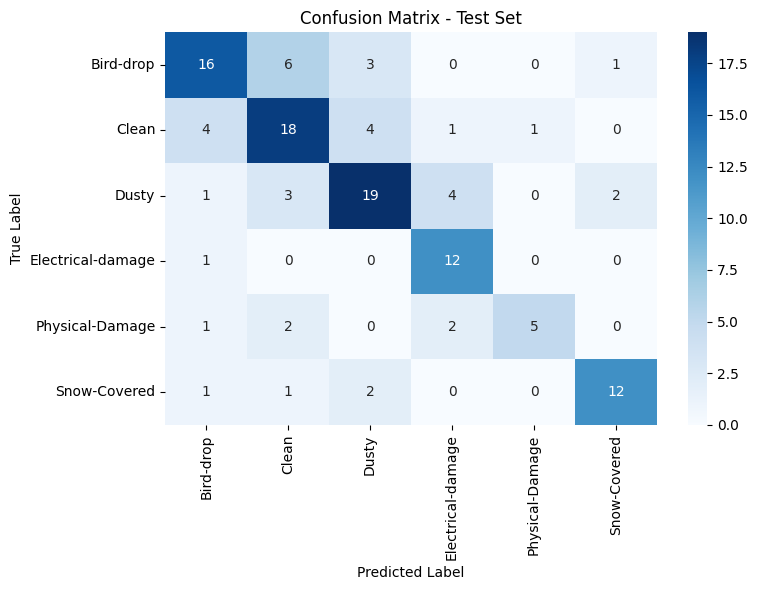

In [8]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred_labels, labels=present_labels.tolist())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

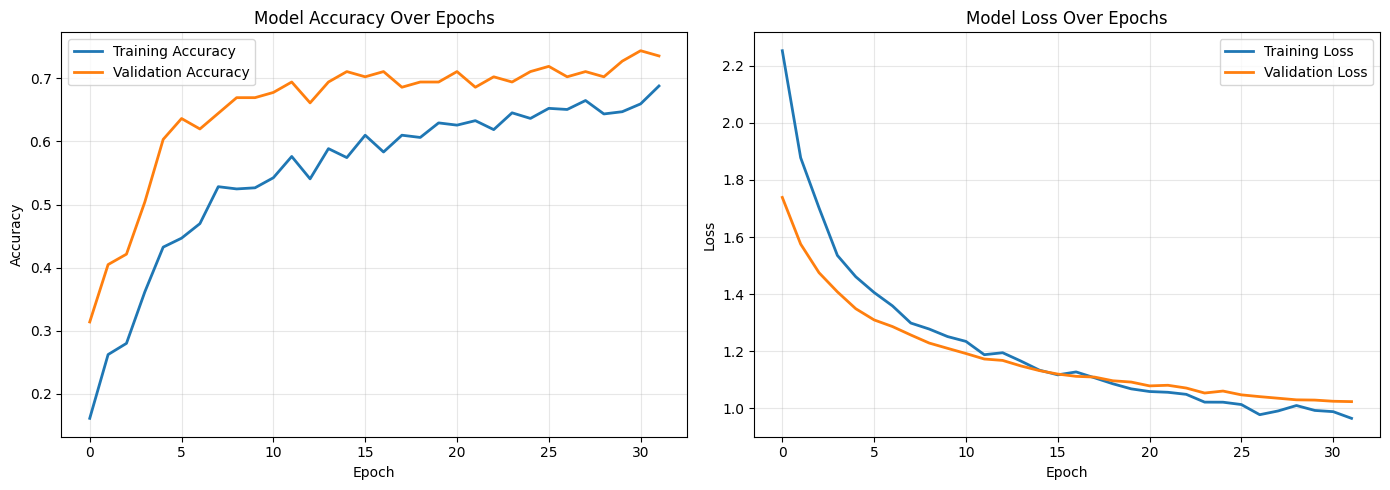


TRAINING SUMMARY
Final Training Accuracy: 0.6879
Final Validation Accuracy: 0.7355
Final Training Loss: 0.9649
Final Validation Loss: 1.0234
Best Validation Accuracy: 0.7438


In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of results
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"{'='*60}")